In [1]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole

In [2]:
# read the smiles data from Reinvent
file_name = 'smiles-100k.smi'

with open(file_name, "r") as ins:
    smiles = []
    for line in ins:
        smiles.append(line.split('\n')[0])
print('# of SMILES:', len(smiles))

# of SMILES: 98280


In [21]:
compounds = [Chem.MolFromSmiles(smi) for smi in smiles]
print(len(compounds))
print(type(compounds))

98280
<class 'list'>


In [4]:
# check the list and what it contains
compounds[:5]

In [5]:
# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol in compounds[:10000]]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))

Number of compounds converted: 10000
Fingerprint length per compound: 2048


In [6]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [7]:
# Example: Calculate single similarity of two fingerprints

sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.27, distance: 0.73


In [8]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:5]

[0.7346072186836519,
 0.7568238213399504,
 0.8118586088939567,
 0.7589134125636672,
 0.8009331259720063]

In [9]:
# Clustering molecules: Centroids and exclusion spheres¶
# In this part, we cluster the molecules and look at the results.

# Define a clustering function.

In [10]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [11]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.3)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)

total # clusters:  9166
# clusters with only 1 compound:  8668
# clusters with >5 compounds:  14
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


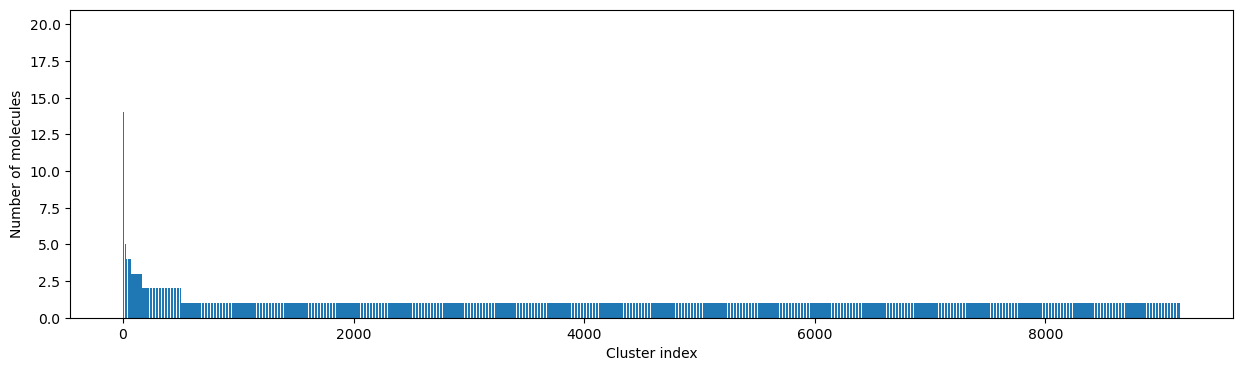

In [12]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

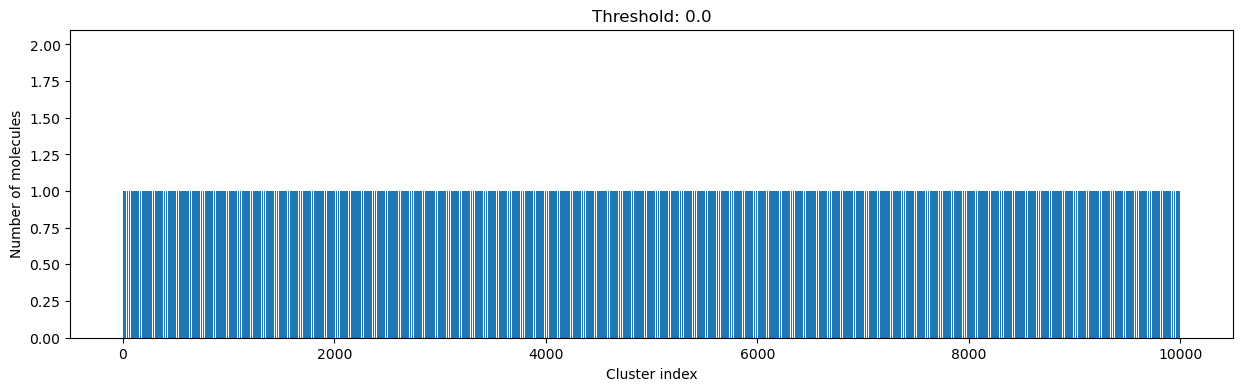

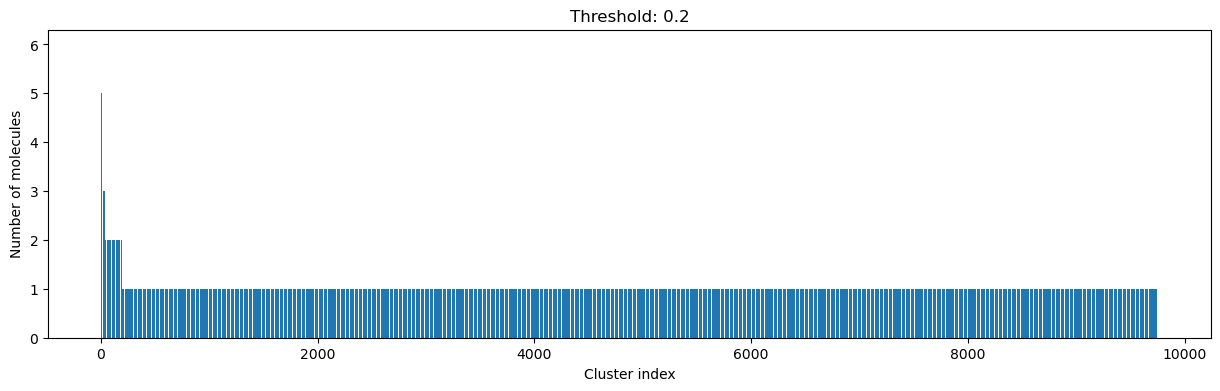

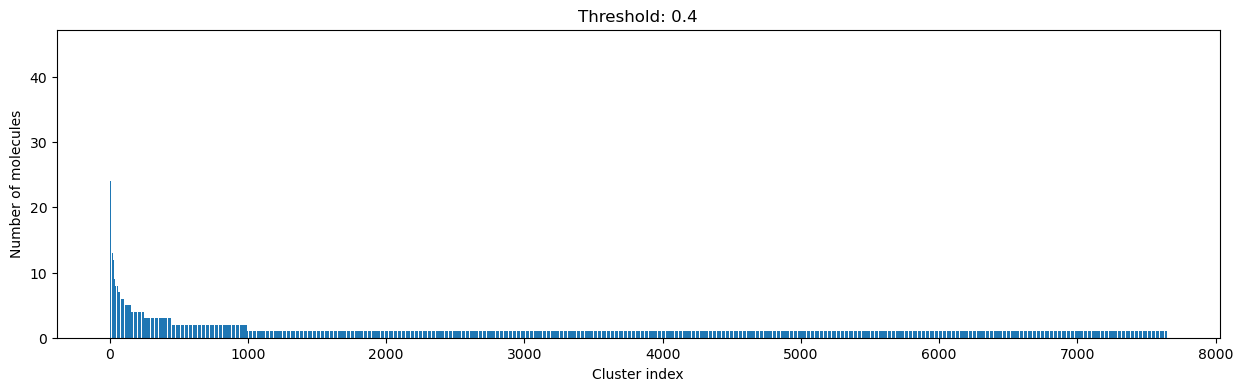

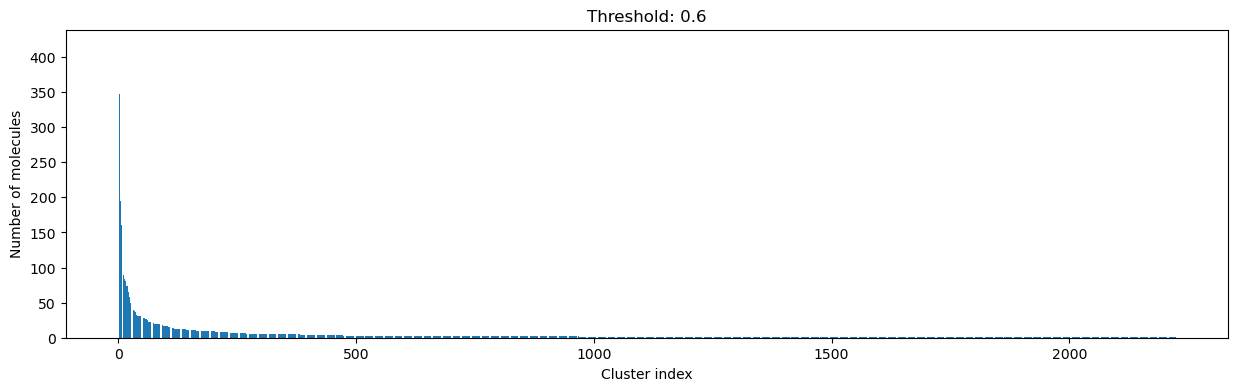

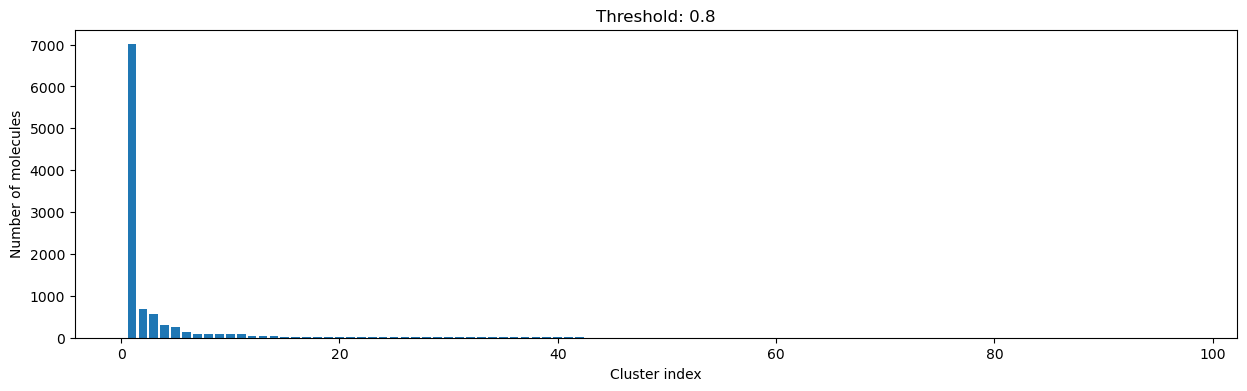

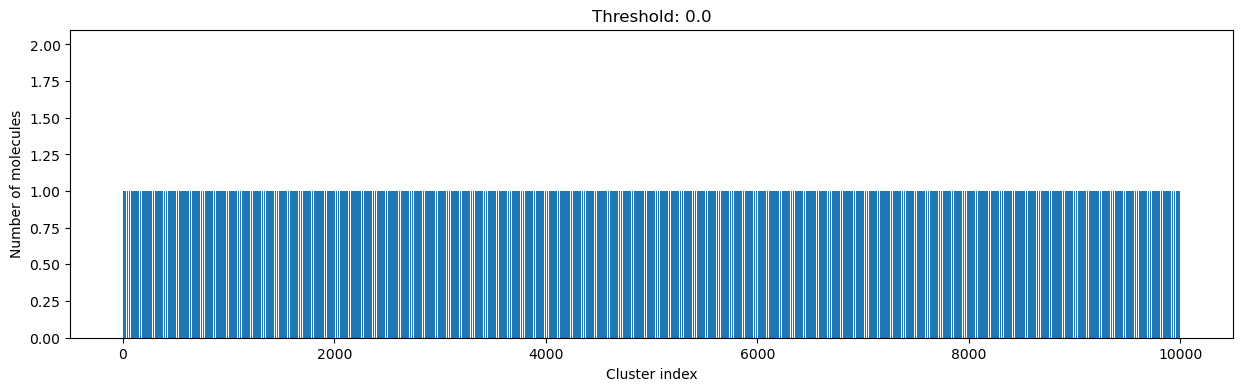

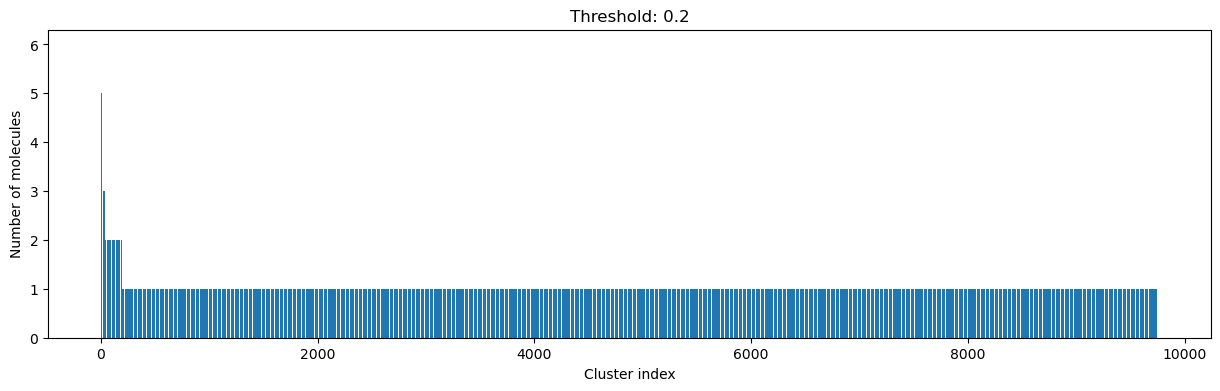

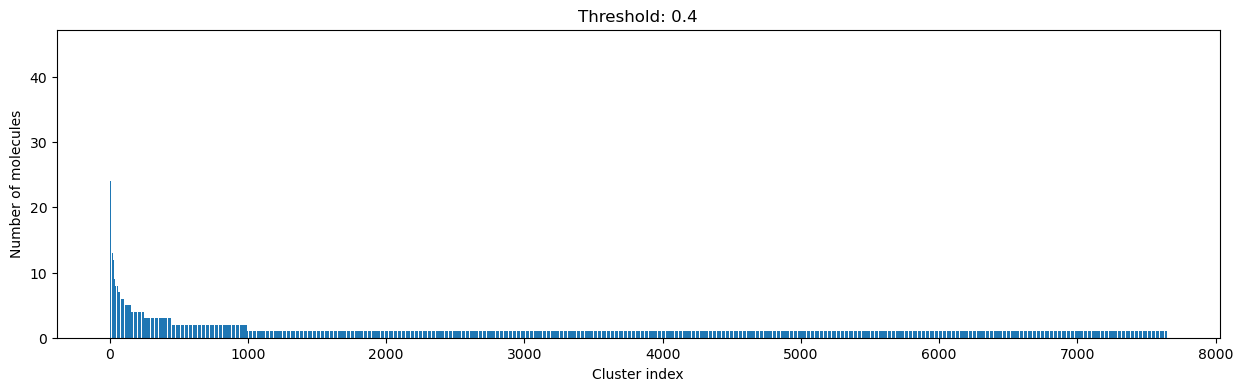

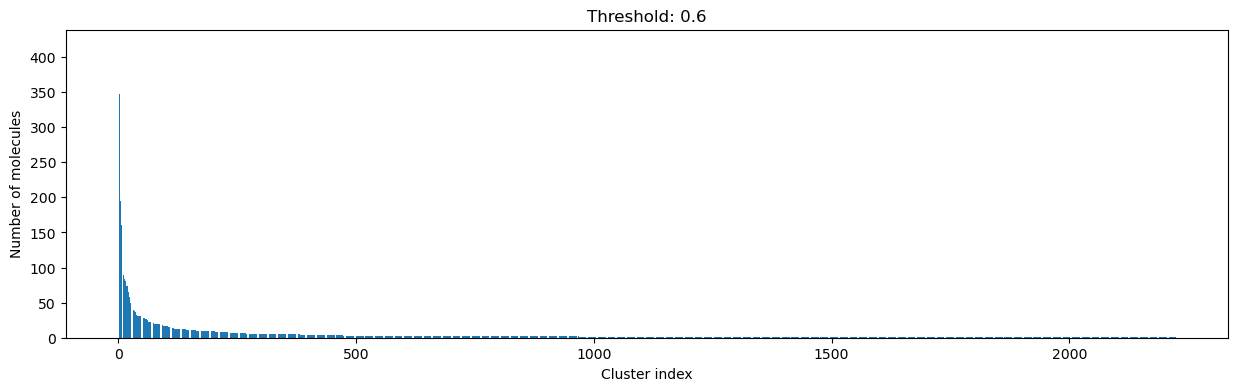

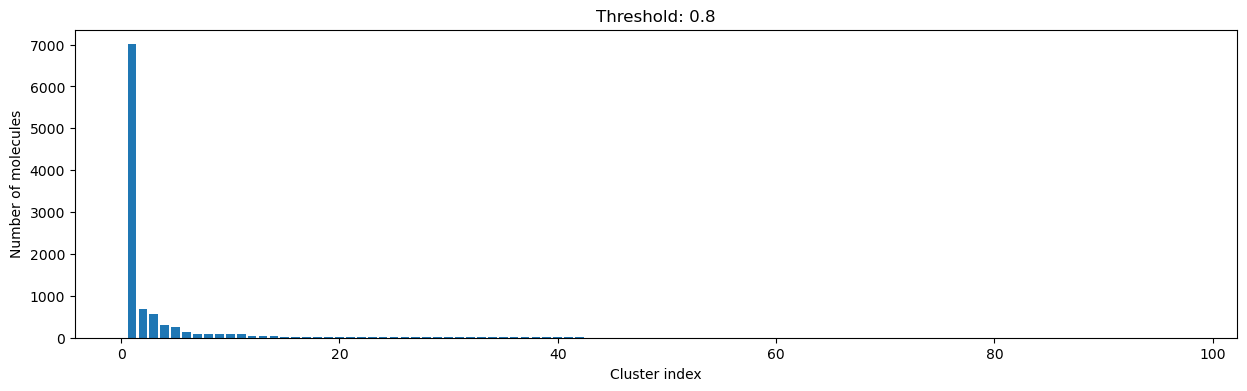

In [14]:
for cutoff in np.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    display(fig)

Number of clusters: 97 from 98280 molecules at distance cut-off 0.80
Number of molecules in largest cluster: 7004
Similarity between two random points in same cluster: 0.24
Similarity between two random points in different cluster: 0.20


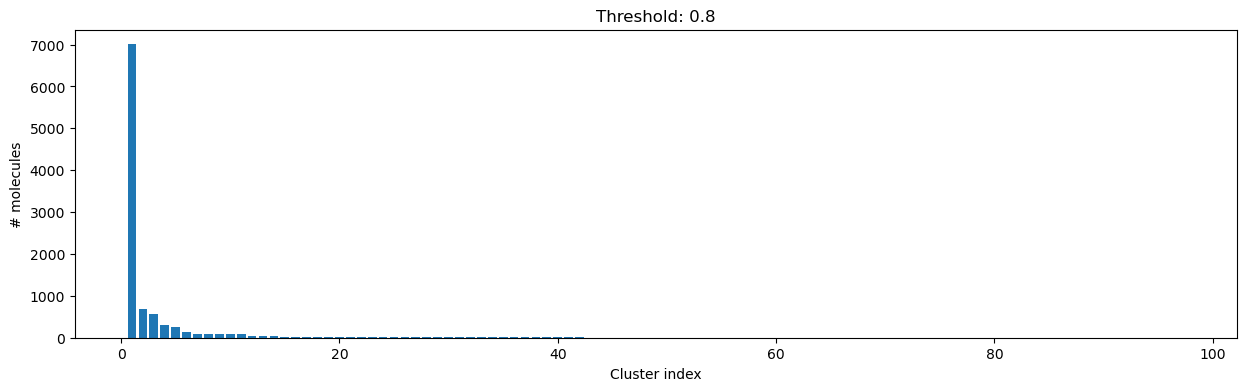

In [15]:
cutoff = 0.8
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


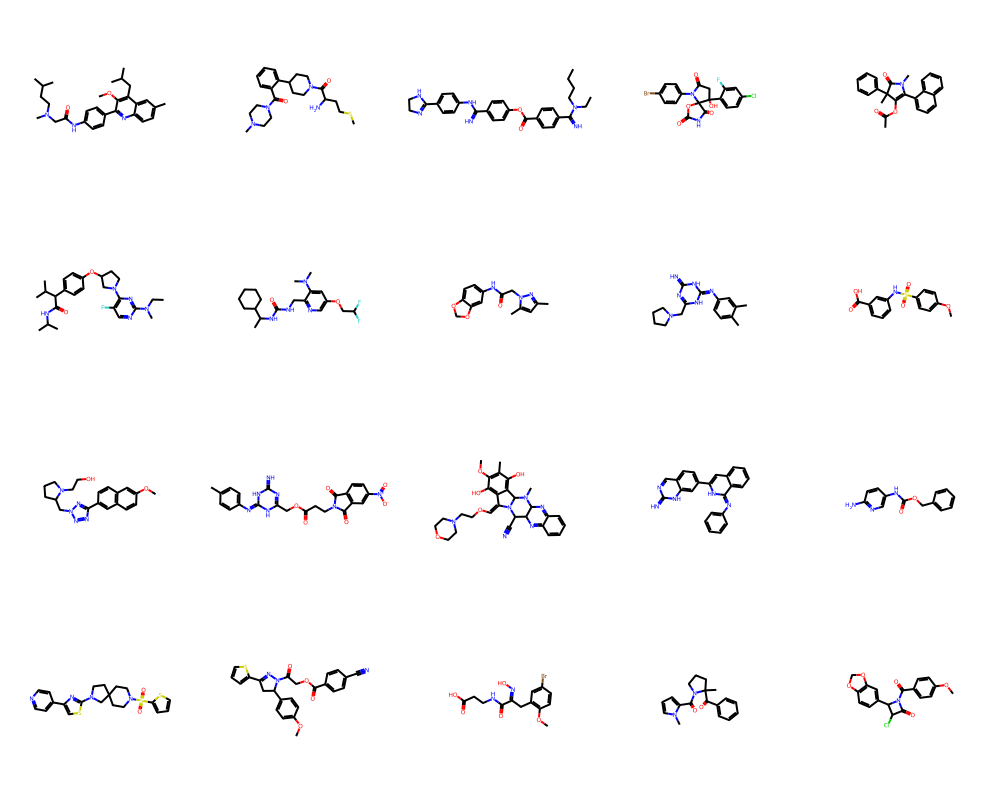

In [41]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i] for i in clusters[0][:20]],
#    legends=[compounds for i in clusters[20]],
    molsPerRow=5,)

In [38]:
# Save molecules from largest cluster
sdf_path = str("molecule_set_largest_cluster.sdf")
sdf = Chem.SDWriter(sdf_path)
for index in clusters[0]:
    mol = compounds[index]
    # Add label to metadata
    #mol.SetProp("_Name", label)
    sdf.write(mol)
sdf.close()

Ten molecules from largest cluster:


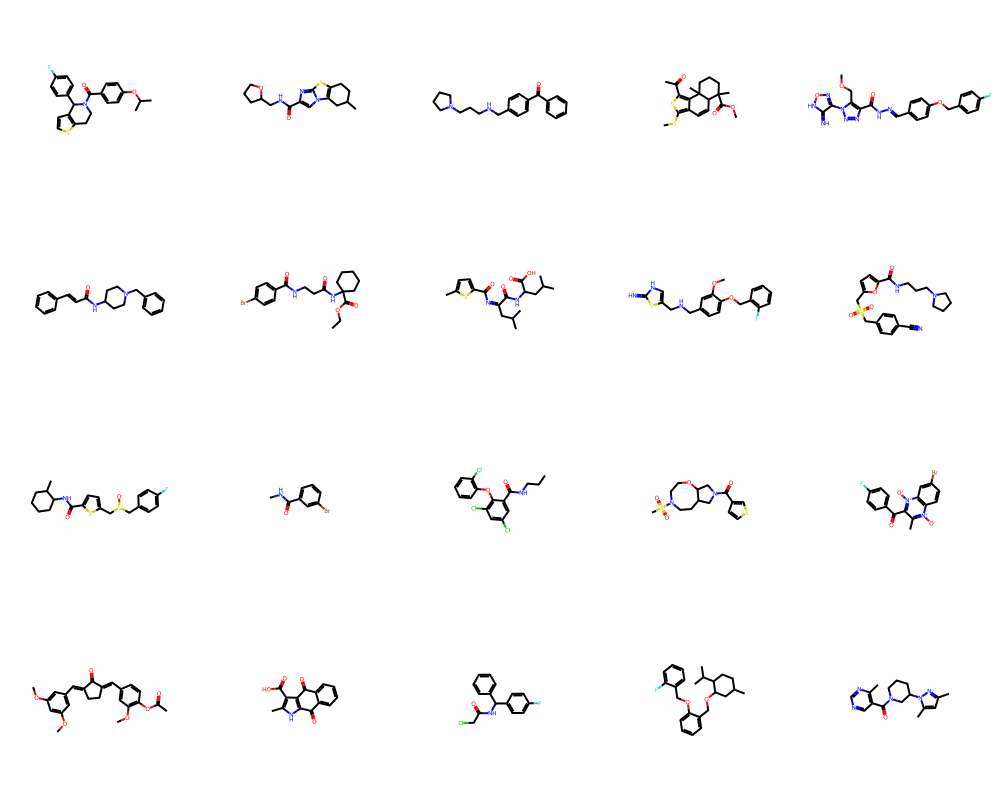

In [42]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i] for i in clusters[1][:20]],
#    legends=[compounds for i in clusters[20]],
    molsPerRow=5,)

In [43]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

In [44]:
# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:10]:
    mol_fps_per_cluster.append([rdkit_gen.GetFingerprint(compounds[i]) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

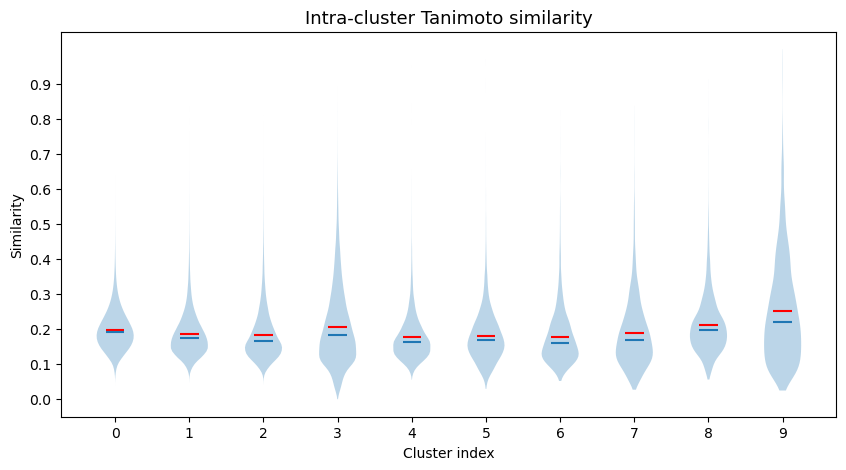

In [47]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(10))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(np.arange(0.0, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue